<a href="https://colab.research.google.com/github/Anze-/datathon2k25/blob/alberto/feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Engineering

# 1. Set up working environment

In [52]:
import pandas as pd
import numpy as np
import csv

In [53]:
# enable GPU if needed, GPU can speed up your vector embedding if you computing these vectors locally (not using API)

import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [54]:
import os
import json
import chromadb
import openai
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.llms import OpenAI
from langchain.chains import RetrievalQA

# Set OpenAI API Key
#os.environ["OPENAI_API_KEY"] = open('api.key').read()[:-1]

# 2. Working on URLs

In [61]:
!ls

1			    feature_engineering.ipynb  pyproject.toml
2025-04-05-Note-10-07.xopp  filtered_urls.parquet      README.md
api.key			    labelurls.txt	       url_filtering.ipynb
env.yml			    main.py		       uv.lock


In [62]:
folder_path = "./data/hackathon_data/"# Google drive path of the dataset
files_in_folder = os.listdir(folder_path)
len(files_in_folder)

13144

In [63]:
def load_documents(json_file):
    """Loads the JSON file."""
    with open(json_file, 'r') as f:
      try:
          data = json.load(f)
          return data
      except json.JSONDecodeError:
          print(f"Error reading {json_file}, it may not be a valid JSON file.")
    return []

In [64]:
def load_urls(file=files_in_folder[0]):
    website_name=file[:-5]
    urldocs=load_documents(folder_path+file)['text_by_page_url']
    return {website_name:list(urldocs.keys())}

In [65]:
load_urls(files_in_folder[0])

{'skysolutions.com': ['http://skysolutions.com',
  'http://skysolutions.com/',
  'https://skysolutions.com/services/',
  'https://skysolutions.com/services/ai-solutions/',
  'https://skysolutions.com/services/ai-solutions/enterprise-data-management-and-platform-enablement/',
  'https://skysolutions.com/services/ai-solutions/ai-ml-and-advanced-analytics/',
  'https://skysolutions.com/services/ai-solutions/generative-ai-platforms-and-solutions/',
  'https://skysolutions.com/services/digital-transformation/',
  'https://skysolutions.com/services/digital-transformation/human-centered-design/',
  'https://skysolutions.com/services/digital-transformation/agile-safe-agile-product-management/',
  'https://skysolutions.com/services/digital-transformation/ci-cd-and-devsecops-practices/',
  'https://skysolutions.com/services/digital-transformation/low-code-no-code-development/',
  'https://skysolutions.com/services/digital-transformation/legacy-modernization-and-cloud-migration/',
  'https://skys

In [10]:
#choose a labeling set

np.random.seed(42)
labeling_set = np.random.choice(files_in_folder,100)

In [11]:
labelurls = []
for L in [list(load_urls(site).values())[0] for site in labeling_set]:
    labelurls.extend(L)

In [12]:
labelurls

['https://nhbb.com/',
 'https://nhbb.com/products',
 'https://nhbb.com/products/ball-roller-bearings',
 'https://nhbb.com/products/miniature-instrument-ball-bearings',
 'https://nhbb.com/products/medium-large-ball-bearings',
 'https://nhbb.com/products/medium-large-cylindrical-roller-bearings',
 'https://nhbb.com/products/thin-section-ball-bearings',
 'https://nhbb.com/products/airframe-control-ball-bearings',
 'https://nhbb.com/products/complex-bearing-assemblies',
 'https://nhbb.com/products/precision-mechanical-subassemblies',
 'https://nhbb.com/products/rod-end-spherical-bearings',
 'https://nhbb.com/products/rod-end-bearings',
 'https://nhbb.com/products/spherical-bearings',
 'https://nhbb.com/products/self-lubricating-sleeve-bearings',
 'https://nhbb.com/products/loader-slots',
 'https://nhbb.com/products/next-assemblies-and-complex-bearing-solutions',
 'https://nhbb.com/products/patented-self-lubricating-liner-solutions',
 'https://nhbb.com/our-company/nhbb-divisions/new-product

## tokenizer

In [39]:
# tokenizer

import tldextract
from urllib.parse import urlparse, parse_qs

def simple_url_tokenizer(url: str):
    # 1. Parse the URL with urllib to get basic components
    parsed_url = urlparse(url)
    
    # 2. Use tldextract to get domain/subdomain
    extracted = tldextract.extract(url)
    
    # 3. Extract components
    scheme = parsed_url.scheme    # 'http', 'https', etc.
    domain = extracted.domain      # 'example'
    subdomain = extracted.subdomain  # 'www'
    path = parsed_url.path        # '/path/to/resource'
    query = parsed_url.query      # 'id=123&name=abc'
    depth = path.count("/")
    # 4. Tokenize path (split into parts by '/')
    path_tokens = path.strip('/').split('/') if path else []
    path_tokens = [tk.split('-') for tk in path_tokens]
    path_tokens = sum(path_tokens,[]) + [scheme]
    concat_tokens = " ".join(path_tokens)



    # 5. Tokenize query parameters (key-value pairs)
    query_tokens = {k: v[0] for k, v in parse_qs(query).items()} if query else {}

    # Return all tokens in a dictionary
    return {
        #'scheme': scheme,
        #'subdomain': subdomain,
        #'domain': domain,
        'path_tokens': concat_tokens,
        'depth': depth
        #'query_tokens': query_tokens
    }

In [76]:
train_url_texts = []
train_url_depth = []



# Apply the tokenizer to each URL
for url in labelurls:
    tokens = simple_url_tokenizer(url)
    print(f"Tokens for URL: {url}")
    print(tokens)
    print("-" * 50)
    train_url_texts.append(tokens["path_tokens"])
    train_url_depth.append(tokens["depth"])

train_url_texts


Tokens for URL: https://nhbb.com/
{'path_tokens': ' https', 'depth': 1}
--------------------------------------------------
Tokens for URL: https://nhbb.com/products
{'path_tokens': 'products https', 'depth': 1}
--------------------------------------------------
Tokens for URL: https://nhbb.com/products/ball-roller-bearings
{'path_tokens': 'products ball roller bearings https', 'depth': 2}
--------------------------------------------------
Tokens for URL: https://nhbb.com/products/miniature-instrument-ball-bearings
{'path_tokens': 'products miniature instrument ball bearings https', 'depth': 2}
--------------------------------------------------
Tokens for URL: https://nhbb.com/products/medium-large-ball-bearings
{'path_tokens': 'products medium large ball bearings https', 'depth': 2}
--------------------------------------------------
Tokens for URL: https://nhbb.com/products/medium-large-cylindrical-roller-bearings
{'path_tokens': 'products medium large cylindrical roller bearings https

[' https',
 'products https',
 'products ball roller bearings https',
 'products miniature instrument ball bearings https',
 'products medium large ball bearings https',
 'products medium large cylindrical roller bearings https',
 'products thin section ball bearings https',
 'products airframe control ball bearings https',
 'products complex bearing assemblies https',
 'products precision mechanical subassemblies https',
 'products rod end spherical bearings https',
 'products rod end bearings https',
 'products spherical bearings https',
 'products self lubricating sleeve bearings https',
 'products loader slots https',
 'products next assemblies and complex bearing solutions https',
 'products patented self lubricating liner solutions https',
 'our company nhbb divisions new product development center https',
 'our company affiliated companies https',
 'industries https',
 'industries aerospace defense https',
 'industries high technology https',
 'industries medical https',
 'knowl

In [81]:
import pandas as pd

labels_for_urls = pd.read_csv("./data/labled_urls.csv")
labels_for_urls.drop("Unnamed: 1", axis=1, inplace=True)
train_url_labels = labels_for_urls["0"]

## model

In [85]:
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

import scipy.sparse as sparse


# 1. Convert text to features using TF-IDF vectorization
vectorizer = TfidfVectorizer()
# 2. Vectorize the text data

X = sparse.hstack([vectorizer.fit_transform(train_url_texts[:len(train_url_labels)]), np.array(train_url_depth[:len(train_url_labels)]).reshape(-1,1)]  )

# 3. Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, train_url_labels, test_size=0.2, shuffle=True, random_state=42)

# 4. Initialize and train the Logistic Regression model
model = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42, solver="lbfgs")
model.fit(X_train, y_train)

# 5. Make predictions on the test set
y_pred = model.predict(X_test)

# 6. Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print results
print("Accuracy:", accuracy)
print("Classification Report:")
print(class_report)





Accuracy: 0.8134328358208955
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90       373
           1       0.12      0.24      0.16        29

    accuracy                           0.81       402
   macro avg       0.53      0.55      0.53       402
weighted avg       0.88      0.81      0.84       402



In [75]:

def prepare_urls(urls):
    url_texts=[]
    url_depth=[]
    for url in urls:
        tokens = simple_url_tokenizer(url)
        url_texts.append(tokens["path_tokens"])
        url_depth.append(tokens["depth"])

    X = sparse.hstack([vectorizer.transform(url_texts), np.array(url_depth).reshape(-1,1)])

    return X

def is_url_important(urls):
    X=  prepare_urls(urls)
    predicted_vals =  model.predict(X)
    return predicted_vals == 1

In [97]:
urls = [list(load_urls(site).values())[0] for site in files_in_folder]

In [104]:
from itertools import chain

flattened_urls = list(chain.from_iterable(urls))
flattened_urls

['http://climbglobalsolutions.com',
 'http://climbglobalsolutions.com/',
 'http://climbglobalsolutions.com/investors',
 'http://climbglobalsolutions.com/investors/news-events',
 'http://climbglobalsolutions.com/investors/news-events/press-releases',
 'http://climbglobalsolutions.com/investors/news-events/ir-calendar',
 'http://climbglobalsolutions.com/investors/news-events/email-alerts',
 'http://climbglobalsolutions.com/investors/company-information',
 'http://climbglobalsolutions.com/investors/company-information/management-team',
 'http://climbglobalsolutions.com/investors/company-information/presentations',
 'http://climbglobalsolutions.com/investors/company-information/contacts',
 'http://climbglobalsolutions.com/investors/company-information/faq',
 'http://climbglobalsolutions.com/investors/financial-information',
 'http://climbglobalsolutions.com/investors/financial-information/financial-results',
 'http://climbglobalsolutions.com/investors/financial-information/income-statement

In [109]:
urls_df = pd.DataFrame(flattened_urls, columns=["url"])
urls_df.head()


,url
0,http://climbglobalsolutions.com
1,http://climbglobalsolutions.com/
2,http://climbglobalsolutions.com/investors
3,http://climbglobalsolutions.com/investors/news...
4,http://climbglobalsolutions.com/investors/news...


In [112]:
filtering_usage = is_url_important(flattened_urls)
filtering_usage.sum()

np.int64(185151)

In [115]:
urls_df["is_filtered"] = filtering_usage
urls_df.to_parquet("filtered_urls.parquet")

## Duplicates removal

In [67]:
urls_df = pd.read_parquet("filtered_urls.parquet")

In [73]:
urls_df[urls_df.is_filtered==True]

,url,is_filtered
4,http://climbglobalsolutions.com/investors/news...,True
40,https://www.climbglobalsolutions.com/investors...,True
41,https://www.climbglobalsolutions.com/investors...,True
49,https://www.climbglobalsolutions.com/investors...,True
50,https://www.climbglobalsolutions.com/investors...,True
...,...,...
768467,http://secv.com/support/online-billpay/,True
768470,https://www.secv.com/internet/agreement/,True
768472,https://www.secv.com/nmd,True
768473,https://www.secv.com,True


In [74]:
# ok, it looks bad, let's filter with other criteria

In [78]:
urls_df['splits'] = urls_df.url.apply(lambda x: x.split('/'))

In [80]:
urls_df['num_splits'] = urls_df.splits.apply(len)

<Axes: >

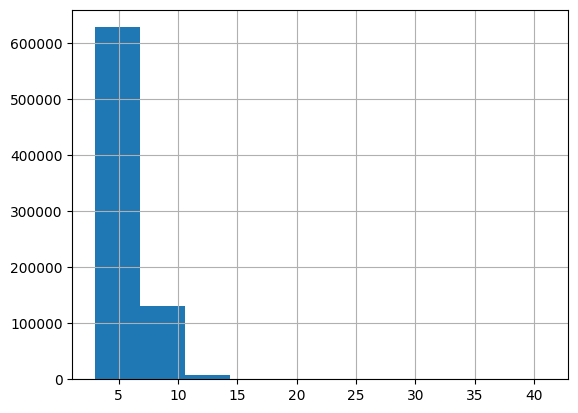

In [84]:
urls_df.num_splits.hist()

In [114]:
urls_df1=urls_df[urls_df['num_splits']<7]

In [174]:
trigger = '.css'
for trigger,name in zip(['.js','.css','/blog/','/article/','/post/','/news/'],['is_js','is_css','is_blog','is_article','is_post','is_news']):
    urls_df1[name] = urls_df1.url.apply(lambda x: trigger in x)

/tmp/ipykernel_86426/2222979193.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  urls_df1[name] = urls_df1.url.apply(lambda x: trigger in x)
/tmp/ipykernel_86426/2222979193.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  urls_df1[name] = urls_df1.url.apply(lambda x: trigger in x)


In [175]:
urls_df1

,url,is_filtered,splits,num_splits,is_js,is_css,is_blog,is_article,is_post,is_news
0,http://climbglobalsolutions.com,False,"[http:, , climbglobalsolutions.com]",3,False,False,False,False,False,False
1,http://climbglobalsolutions.com/,False,"[http:, , climbglobalsolutions.com, ]",4,False,False,False,False,False,False
2,http://climbglobalsolutions.com/investors,False,"[http:, , climbglobalsolutions.com, investors]",4,False,False,False,False,False,False
3,http://climbglobalsolutions.com/investors/news...,False,"[http:, , climbglobalsolutions.com, investors,...",5,False,False,False,False,False,False
4,http://climbglobalsolutions.com/investors/news...,True,"[http:, , climbglobalsolutions.com, investors,...",6,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
768473,https://www.secv.com,True,"[https:, , www.secv.com]",3,False,False,False,False,False,False
768474,http://secv.com/css/features.css?v=1.35,True,"[http:, , secv.com, css, features.css?v=1.35]",5,False,True,False,False,False,False
768475,http://secv.com/freeplume,False,"[http:, , secv.com, freeplume]",4,False,False,False,False,False,False
768476,http://secv.com/freetivo,False,"[http:, , secv.com, freetivo]",4,False,False,False,False,False,False


In [176]:
urls_df2 = urls_df1[(urls_df1.is_css==False) & (urls_df1.is_js==False)  & (urls_df1.is_blog==False) & (urls_df1.is_article==False) & (urls_df1.is_post==False) & (urls_df1.is_news==False)]

In [177]:
#remove HTTP/S duplicates

# Step 1: Create a normalized column (strip http/https)
urls_df2['normalized'] = urls_df2['url'].str.replace(r'^https?://', '', regex=True)

# Step 2: Sort so that https comes first (we want to keep https)
urls_df2['https_first'] = urls_df2['url'].str.startswith('https')
urls_df2 = urls_df2.sort_values(by='https_first', ascending=False)

# Step 3: Drop duplicates based on normalized version, keeping the first (https preferred)
urls_df2 = urls_df2.drop_duplicates(subset='normalized', keep='first')

# Step 4: Drop helper columns
urls_df3 = urls_df2.drop(columns=['normalized', 'https_first'])

/tmp/ipykernel_86426/3706498202.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  urls_df2['normalized'] = urls_df2['url'].str.replace(r'^https?://', '', regex=True)
/tmp/ipykernel_86426/3706498202.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  urls_df2['https_first'] = urls_df2['url'].str.startswith('https')


In [217]:
# remove trailing slash

# Step 1: Normalize by removing scheme and trailing slash
urls_df3['normalized'] = urls_df3['url'].str.replace(r'^https?://', '', regex=True).str.rstrip('/')

# Step 2: Prefer https (create boolean flags)
urls_df3['is_https'] = urls_df3['url'].str.startswith('https')
urls_df3['no_trailing_slash'] = ~urls_df3['url'].str.endswith('/')

# Step 3: Sort to prefer https and no trailing slash
urls_df3 = urls_df3.sort_values(by=['is_https', 'no_trailing_slash'], ascending=[False, False])

# Step 4: Drop duplicates on normalized version
urls_df3 = urls_df3.drop_duplicates(subset='normalized', keep='first')

# Step 5: Clean up
urls_df3 = urls_df3.drop(columns=['normalized', 'is_https', 'no_trailing_slash'])

In [218]:
# now lets find pages that we are interested in

In [219]:
home_urls = urls_df3[urls_df3.num_splits==3]
about_urls = urls_df3[urls_df3.splits.apply(lambda x : 'about' in ' '.join(x[3:]) )]
contact_urls = urls_df3[urls_df3.splits.apply(lambda x : 'contact' in ' '.join(x[3:]) )]
technology_urls = urls_df3[urls_df3.splits.apply(lambda x : 'technology' in ' '.join(x[3:]) )]
product_urls = urls_df3[urls_df3.splits.apply(lambda x : 'product' in ' '.join(x[3:]) )]
service_urls = urls_df3[urls_df3.splits.apply(lambda x : 'service' in ' '.join(x[3:]) )]
work_urls = urls_df3[urls_df3.splits.apply(lambda x : 'work' in ' '.join(x[3:]) )]
capability_urls = urls_df3[urls_df3.splits.apply(lambda x : 'capabil' in ' '.join(x[3:]) )]
industry_urls = urls_df3[urls_df3.splits.apply(lambda x : 'industr' in ' '.join(x[3:]) )]

In [220]:
keyword_dfs = [home_urls,about_urls,contact_urls,technology_urls,product_urls,service_urls,work_urls,capability_urls,industry_urls]

In [224]:
keyword_dfs

[                                url  is_filtered  \
 351539   https://tintranslation.com         True   
 351791        https://imagen-ai.com         True   
 351681       https://www.entltd.com         True   
 351145     https://westerntitle.com         True   
 352327  https://www.psgconsults.com         True   
 ...                             ...          ...   
 368532     http://hollywoodpnrc.com        False   
 368147               http://trg.com        False   
 368734            http://mulfil.com        False   
 368664     http://aistechnolabs.com        False   
 368594  http://luttrellstaffing.com        False   
 
                                  splits  num_splits  is_js  is_css  is_blog  \
 351539   [https:, , tintranslation.com]           3  False   False    False   
 351791        [https:, , imagen-ai.com]           3  False   False    False   
 351681       [https:, , www.entltd.com]           3  False   False    False   
 351145     [https:, , westerntitle.com]  

In [225]:
len(keyword_dfs)

9

In [228]:
from urllib.parse import urlparse

def get_domain(url):
    return urlparse(url).netloc

# Process each DataFrame
processed_dfs = []
for df in keyword_dfs:
    df['domain'] = df['url'].apply(get_domain)
    # Keep the row with the smallest num_splits per domain
    df_grouped = df.loc[df.groupby('domain')['num_splits'].idxmin()]
    processed_dfs.append(df_grouped.drop(columns='domain'))  # drop helper column if not needed

/tmp/ipykernel_86426/3210399472.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['domain'] = df['url'].apply(get_domain)
/tmp/ipykernel_86426/3210399472.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['domain'] = df['url'].apply(get_domain)
/tmp/ipykernel_86426/3210399472.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [230]:
combined_df = pd.concat(processed_dfs, ignore_index=True)
combined_df = combined_df.drop_duplicates(subset='url')

In [233]:
combined_df['domain'] = combined_df['url'].apply(get_domain)

In [236]:
combined_df

,url,is_filtered,splits,num_splits,is_js,is_css,is_blog,is_article,is_post,is_news,domain
0,https://1-vision.com,True,"[https:, , 1-vision.com]",3,False,False,False,False,False,False,1-vision.com
1,http://100coaches.com,False,"[http:, , 100coaches.com]",3,False,False,False,False,False,False,100coaches.com
2,https://101financial.com,True,"[https:, , 101financial.com]",3,False,False,False,False,False,False,101financial.com
3,http://1021creative.com,False,"[http:, , 1021creative.com]",3,False,False,False,False,False,False,1021creative.com
4,https://10roadsexpress.com,True,"[https:, , 10roadsexpress.com]",3,False,False,False,False,False,False,10roadsexpress.com
...,...,...,...,...,...,...,...,...,...,...,...
49908,https://www.westonandsampson.com/industries/,True,"[https:, , www.westonandsampson.com, industrie...",5,False,False,False,False,False,False,www.westonandsampson.com
49909,https://www.wirtzusa.com/equipments/wirtz-indu...,False,"[https:, , www.wirtzusa.com, equipments, wirtz...",6,False,False,False,False,False,False,www.wirtzusa.com
49910,https://www.woh.com/industries/,True,"[https:, , www.woh.com, industries, ]",5,False,False,False,False,False,False,www.woh.com
49912,https://www.wvpa.com/industry-expertise/,False,"[https:, , www.wvpa.com, industry-expertise, ]",5,False,False,False,False,False,False,www.wvpa.com
